In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()


 ## Linearisation

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The linear life lifts all spirits*



 The general state space representation doesn't have so many assumptions, which is great, however, it's also not very useful for analysis. Now we will assume something that **very** often isn't true, but most of control science is built around this wonderful assumption: *linearity*. There is an easy solution for systems that aren't linear, linearisation and forget anything ever happened!



 Linearisation isn't super difficult: it's just a first order Taylor expansion of $f$ around an equilibrium point. So

 $$f(x,u) \approx f(\bar x, \bar u) + \underbrace{\left.\frac{\partial f(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_A \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial f(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_B \underbrace{(u-\bar u)}_u$$

 $$h(x,u) \approx h(\bar x, \bar u) + \underbrace{\left.\frac{\partial h(x,u)}{\partial x}\right|_{(\bar x, \bar u)}}_C \underbrace{(x-\bar x)}_x + \underbrace{\left.\frac{\partial h(x,u)}{\partial u}\right|_{(\bar x, \bar u)}}_D \underbrace{(u-\bar u)}_u.$$

 If we are extremely intelligent, we can translate $f$ beforehand such that $f(\bar x, \bar u)=0$, perform the underbraced substitutions, and commit some proper notation heresy to end up with the prettiest equation of all: *the linear state space*

 $$ \dot x = A x + B u $$

 $$ y = C x + D u .$$



 $\frac{\partial f(x,u)}{\partial x}$ is called the Jacobian of $f$. A nice memory support is to remember that the Jacobian is multiplied with the state from the right such that each state derivative is multiplied with the same state, so the states vary horizontally and the function elements vertically.



 ## Stability

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Most control engineers aren't as stable as their systems*



 If you know epsilon-delta proofs, I'm sorry for your loss. There is an epsilon-delta definition of stability in the slides, have fun. For normal people stability means that a certain system trajectory stays bounded under bounded inputs. Even simpler: a stable system always returns to certain points. The stability of certain equilibria is easy to assess, since the linearisation is a good approximation locally at the equilibrium point, the stability of the linearised system indicates the stability of the equilibrium point too.



 ### Stability of linear systems

 So assessing the stability of linear systems is important for all types of systems. Before, we already saw some notions of stability in the context of the characteristic polynomial of systems. There are two interesting relations there:

 1. The characteristic polynomial is equivalent to det($sI-A$) for complex $s$.

 2. The roots of the characteristic polynomial are equivalent to the eigenvalues of $A$.



 That second point sounds familiar! We already saw stability related to the roots of the characteristic polynomial before. So, the eigenvalues of $A$, $\Lambda$, reveal the stability of the system. Surprisingly though, there are three types of stability, not two:

 1. Unstable $\leftarrow \exists\mathfrak{R}(\lambda)>0, \lambda\in\Lambda$.

 2. Neutrally stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$ with at most one eigenvalue at 0 or on conjugate pair with real part 0.

 3. Assymptotically stable $\leftarrow \mathfrak{R}(\lambda)\leq 0, \forall\lambda\in\Lambda$.



 These things are nicely visualised for two dimensional system, so you can guess it: have look at the code block!

Eigenvalues are:
[-0.25+2.2220486j -0.25-2.2220486j]
Eigenvectors are:
[[ 0.91287093+0.j          0.91287093-0.j        ]
 [-0.04564355+0.40568871j -0.04564355-0.40568871j]]


<IPython.core.display.Javascript object>

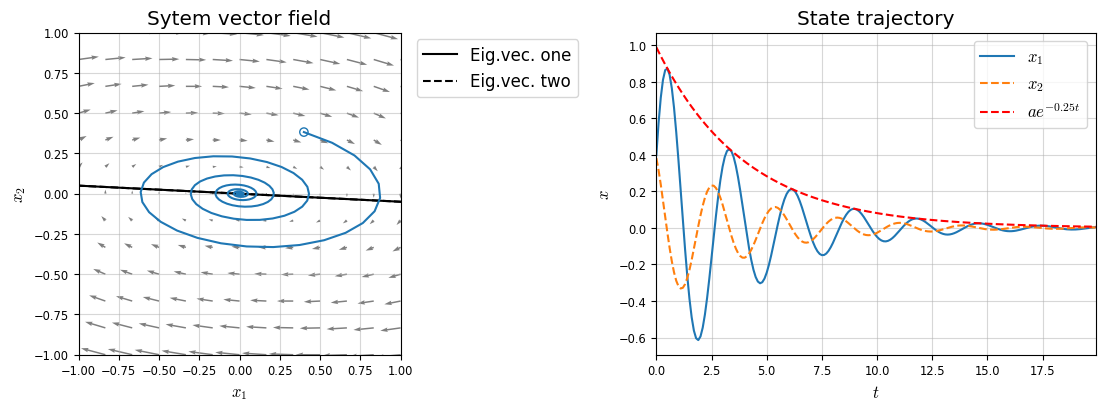

In [19]:
if True: # Toggle between defining A or eigenvalues
    # Define A
    A = np.array([[0, 5],
                [-1, -.5]])
    # A = np.array([[0, 5],[-1, -.5]]) is interesting
else:
    if 'A' in locals(): del A
    if 'v1' in locals(): del v1, v2

    # Define eigenvalues
    lambda1 = -.3
    lambda2 = -.1

    ## Optionally, you can also define the eigenvectors, otherwise they're random and perpendicular
    v1 = np.array([[2],[1]])
    v2 = np.array([[4],[-1]])

###### Processing and Plotting #########
if 'A' not in locals():
    if 'v1' not in locals():
        v1 = rng.randn(2, 1)
        v2 = np.array([[0,-1],[1, 0]])@v1

    T = np.append(v1, v2, axis=1)
    A = T@np.diag([lambda1, lambda2])@lin.inv(T)
    print(f"A is {A}")
else:
    e, v = lin.eig(A)
    print(f"Eigenvalues are:"), print(e)
    print(f"Eigenvectors are:"), print(v)
    v1 = v[:,0][:,np.newaxis]
    v2 = v[:,1][:,np.newaxis]
    lambda1 = e[0]
    lambda2 = e[1]

fig, ax = plt.subplots(1,2)
ax[0].set(aspect="equal", title="Sytem vector field")
vector_field(A=A, v1=v1, v2=v2, ax=ax[0], n=13)

## Create trajectory
traj = np.full([2, 200], np.nan)
traj[:,[0]] = rng.rand(2,1)
h = 0.1
for idx in range(max(traj.shape)-1):
    traj[:, idx+1] = RK4(x=traj[:, idx], dx=lambda x: A@x, h=h)
ax[0].plot(traj[0,:], traj[1,:])
ax[0].scatter(traj[0,0], traj[1,0], marker='o', color='tab:blue', facecolors='none')

T = np.arange(max(traj.shape))*h
l1, = ax[1].plot(T, traj[0,:], label="$x_1$")
l2, = ax[1].plot(T, traj[1,:], '--', label="$x_2$")

if np.iscomplex(lambda1):
    peakIdx, _ = signal.find_peaks(traj[0,:])
    l3, = ax[1].plot(T, traj[0,peakIdx[0]]*np.exp((T-T[peakIdx[0]])*np.real(lambda1)), 'r--', label=f"$a e^{"{"}{np.real(lambda1)}t{"}"}$")
    ax[1].legend(handles=[l1,l2,l3])
else:
    ax[1].legend(handles=[l1,l2])

ax[1].set(xlim=[0, max(T)], title="State trajectory", xlabel="$t$", ylabel="$x$")
display(fig)


 ### How to be an eigenvalue wizard

 Ever had *one of those people* look at a matrix and fully describe its behaviour in a second. Then you check and they're right and you have to take a moment to contemplate if that imposter syndrome might not be as fake as you hoped? Yeah...



 Anyways here are some tricks:

 1. A diagonal matrix has its eigenvalues on the diagonal.

 2. A triangular matrix also has its eigenvalues on the diagonal.

 3. Block diagonal matrices are the union of the eigenvalues of the blocks.

 4. Have a look at the [Jordan normal form](https://en.wikipedia.org/wiki/Jordan_normal_form) if you want, it's also triangular.

 5. The sum of all eigenvalues is the trace of the matrix.

 6. The product of all eigenvalues is the determinant of the matrix.

 7. If $\lambda_k$ are the eigenvalues of $A$, then the eigenvalues of $A^{-1}$ are $1/\lambda_k$.



 ## Coordinate transform

 Sometimes we want to change the coordinate base of our states, either to give them physical meaning or to cast $A$ into a simpler form. This is rather easy linear algebra, lets say the new state $z=Tx \rightarrow x = T^{-1}z$. Then we can substitute that into the state space representation

 $$ \dot x = Ax + Bu \rightarrow T^{-1}\dot z = AT^{-1}z + Bu \rightarrow \dot z = \underbrace{TAT^{-1}}_{\tilde A} z + \underbrace{TB}_{\tilde B}u = \tilde A z + \tilde B u.$$

 and

 $$ y = Cx + Du \rightarrow y = \underbrace{CT^{-1}}_{\tilde C}z + Du = \tilde C z + Du.$$

 **Important: note that the input/output behaviour remains unchanged under state transformations. This is only a system-internal operation.**



 For systems with unique eigenvalues, the system is called diagonalisable, because taking the inverse transformation, $T^{-1}$, to be the horizontally stacked eigenvectors of $A$ results in a diagonal $\tilde A$. Sometimes stuff is named nice and descriptive.

 <div style="text-align:center;background-color:tomato;">End of lecture 4</div>

 ## Reachability

 So there is a nice closed form expression of system trajectories given any input!  By convolution of the input, we can express the state and output trajectory of any LTI system as

 $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$$

 and

 $$ y(t) = Cx(t) + Du(t) = Ce^{At}x_0 + \int_0^t Ce^{A(t-\tau)}Bu(\tau)d\tau + Du(t).$$

 Here, the first term is the effect of the initial condition, the second term is influenced by the input and the third term is the direct feedthrough.



 This output trajectory expression answers some interesting questions too: what states are we able to control the system to? This is called the reachability of the system! Remember we have equilibria $(\bar x, \bar u) \leftarrow A\bar x + B\bar u = 0$? Well then if $A$ is invertible this means that $\bar x = -A^{-1}B\bar u$. So, if $A^{-1}B$ is full rank, we can attain any steady state we'd desire!



 This only answers steady state reachability, what can we reach in transient manners though? That's slightly more involved, but not too bad. Lets look back at the expression

 $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau,$$

 then the interesting part is $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau = \int_0^t e^{At}Bu(t-\tau)d\tau$ and especially $e^{At}B$, because this factor we can't influence with the input. The term with the initial condition can be compensated for anyways.



 ### Cayley–Hamilton theorem

 Our bestest buddies Cayley and Hamilton came up with a theorem that we need to understand the factor $e^{At}$ better. Quick reminder of how Taylor series  worked (around 0 specifically (also called MacLaurin series if you want to do some barefaced fame stealing)):

 $$ f(x) = \sum_{k=0}^{\infty}\frac{f^{(k)}(0)}{k!}x^k = \sum_{k=0}^{\infty}\alpha_k(x) f^{(k)}(0).$$

 Also remember how exponential derivatives worked:

 $$e^{At} \overset{d/dt}{\rightarrow} Ae^{At} \overset{d/dt}{\rightarrow} A^2e^{At} \overset{d/dt}{\rightarrow} A^3e^{At} \overset{d/dt}{\rightarrow} ... \Rightarrow \frac{d^k}{d^kt}e^{At} = A^ke^{At}.$$



 Looks like we're getting somewhere, what if we substitute that derivative expression into the **Taylor** series and recall that $e^{0A}=I$, then

 $$ e^{At} = \sum_{k=0}^{\infty}\alpha_k(x) A^k.$$

 One step closer still! Now lets right multiply with $B$ and write the summation as a matrix multiplication

 $$ e^{At}B =  \mathbf{\alpha}(t)\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}, \qquad \alpha_k(t)=\frac{t^k}{k!}.$$



 So if $\begin{bmatrix}B & AB & A^2B & A^3B & \cdots \end{bmatrix}$ has full row rank, we can use the input to make $\int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$ anything we want, so we can make $x(t)$ anything we want!! This is the reachability criterion and we actually only have to check the first $n-1$ powers of $A$. This forms the so called reachability matrix (also called controllability matrix),

 $$ W_r = \begin{bmatrix}B & AB & A^2B & A^3B & \cdots & A^{n-1}B\end{bmatrix}.$$

 So if this $W_r$ of the pair $(A,B)$ is full rank, the system is reachable (or controllable).



 There is also a coordinate transform to something called the reachable canonical form. It's in the slides but not very useful in this explanation.

 <div style="text-align:center;background-color:tomato;">End of lecture 5</div>

 ## Placing poles is an art

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Art with maths is the best kind of art.*



 We'll look at what behaviour various poles show now, since we'll be designing controllers (!!) in the next part by placing poles. Poles often come in conjugate pairs, so for some generality we'll look at the second-order ODE

 $$ \ddot q + 2\zeta\omega_0\dot q + \omega_0^2 = k\omega_0^2 u.$$

 Here, $\omega_0$ is called the natural frequency and $\zeta$ the damping ratio. Then, the characteristic polynomial is

 $$s^2 + 2\zeta\omega_0s + \omega_0^2,$$

 with roots/poles at $\lambda = -\zeta\omega_0\pm\omega_0\sqrt{\zeta^2-1}$. Time to play around again!

<IPython.core.display.Javascript object>

$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{\zeta^2-1} = -1.040+0.780j$

$|\lambda_1| = \omega_0 = 1.300$

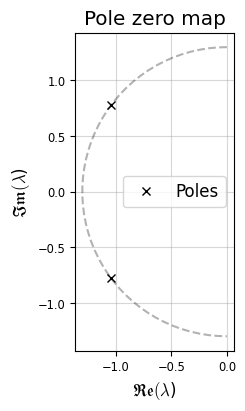

In [15]:
omega0 = 1.3    #CHANGEME
zeta = .8       #CHANGEME

s = cm.tf('s')
P_2d = 1/(s**2 + 2*zeta*omega0*s + omega0**2)

### Plotting ###
fig, ax = plt.subplots()
ax.plot(np.real(P_2d.poles()), np.imag(P_2d.poles()), 'kx', label="Poles")
circ = omega0*np.exp(np.linspace(0.5,1.5)*np.pi*1j)
ax.plot(circ.real, circ.imag, 'k--', alpha=.3)
ax.set(title="Pole zero map", xlabel=r"$\mathfrak{Re}(\lambda$)", ylabel=r"$\mathfrak{Im}(\lambda$)", aspect='equal')
ax.legend()

display(Markdown(rf'$\lambda_1 = -\zeta\omega_0+\omega_0\sqrt{"{"}\zeta^2-1{"}"} = {-zeta*omega0 + omega0*np.emath.sqrt(zeta**2-1):.3f}$'))
display(Markdown(rf'$|\lambda_1| = \omega_0 = {np.abs(P_2d.poles()[0]):.3f}$'))
display(fig)


 Now lets look at the step responses! We have three (or four) terms for intervals of $\zeta$:

 1. $\zeta>1$ is overdamped

 2. $\zeta=1$ is critically damped

 3. $\zeta\in [0,1]$ is underdamped

 4. and $\zeta<0$ is unstable.



 Also the speed of the response is defined by $\omega_0$. We'll plot a few of these.

<IPython.core.display.Javascript object>

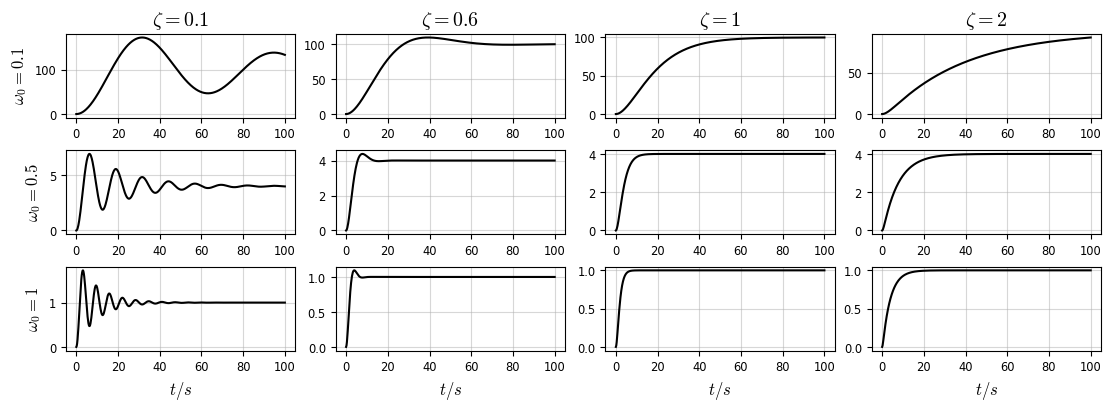

In [16]:
# You can put in whatever and any number of values you want
Omega0 = [.1, .5, 1]
Zeta = [0.1, 0.6, 1, 2]

### Plotting ###
fig, ax = plt.subplots(len(Omega0), len(Zeta))
T = np.linspace(0, 100, 500)

for omega0, axIdx1 in zip(Omega0, range(len(Omega0))):
    for zeta, axIdx2 in zip(Zeta, range(len(Zeta))):
        Pq = cm.ss(1/(s**2 + 2*zeta*omega0*s + omega0**2), dt=0)
        response = cm.forced_response(Pq, T=T, U=np.ones_like(T))
        ax[axIdx1, axIdx2].plot(response.time, response.outputs, 'k')

[ax[0,p].set(title=f"$\zeta={Zeta[p]}$") for p in range(len(Zeta))]
[ax[p,0].set(ylabel=f"$\omega_0={Omega0[p]}$") for p in range(len(Omega0))]
[ax[2,p].set(xlabel=f"$t/s$") for p in range(len(Zeta))]
display(fig)


 ### Why are second order systems so important?

 It turns out that system behaviour is largely dictated by the dominant eigenvalue pair (equivalently, the slowest pair, the pair with the largest real value). If there are pole pairs with the same real value, the pair with the lowest damping ratio $\zeta = -\frac{\mathfrak{R}(\lambda)}{|\lambda|}$ is the dominant pair.



<IPython.core.display.Javascript object>

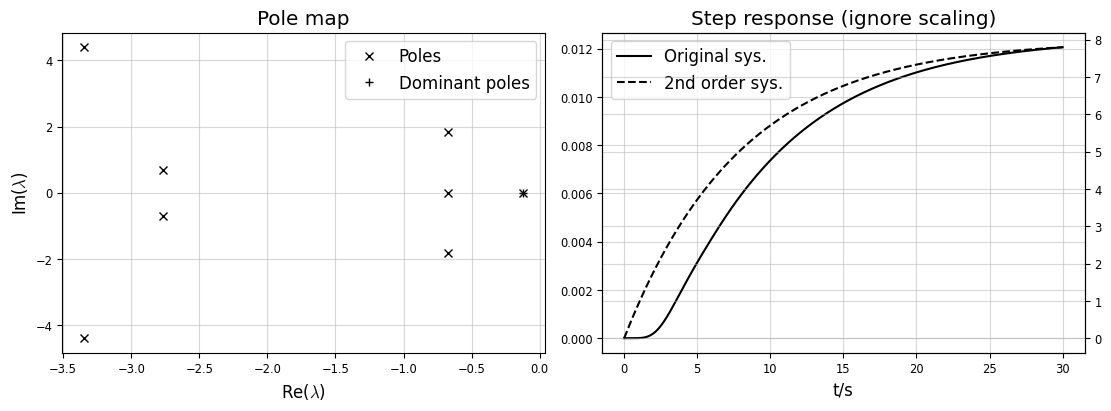

In [23]:
# Create random system
P_dom = cm.rss(8)
P_dom = cm.ss(cm.zpk(poles=P_dom.poles(), zeros=[], gain=1, dt=0))

# Find dominant poles
poles = P_dom.poles()
DomRe = poles.real.max()
DomPoles = poles[np.abs(poles.real / DomRe -1) < 1e-4]

if len(DomPoles) > 2:
    dampRatio = -np.real(DomPoles)/np.abs(DomPoles)
    DomPoles2d = DomPoles[dampRatio == min(dampRatio)]
else:
    DomPoles2d = DomPoles

P_dom_2d = cm.ss(cm.zpk(poles=DomPoles2d, zeros=[], gain=1, dt=0))

T_dom = np.linspace(0, 30, 500)
response_dom =    cm.forced_response(P_dom,    T=T_dom, U=np.ones_like(T_dom))
response_dom_2d = cm.forced_response(P_dom_2d, T=T_dom, U=np.ones_like(T_dom))

fig, ax = plt.subplots(1, 2)
ax[0].plot(P_dom.poles().real, P_dom.poles().imag, 'kx', label="Poles")
ax[0].plot(P_dom_2d.poles().real, P_dom_2d.poles().imag, 'k+', label="Dominant poles")
ax[0].set(title="Pole map", xlabel="Re($\lambda$)", ylabel="Im($\lambda$)")
ax[0].legend()


l0 = ax[1].plot(response_dom.time, response_dom.outputs, 'k', label="Original sys.")
l1 = ax[1].twinx().plot(response_dom_2d.time, response_dom_2d.outputs, 'k--', label="2nd order sys.")
ax[1].legend(handles = [l0[0], l1[0]])
ax[1].set(title="Step response (ignore scaling)", xlabel="t/s")
display(fig)
